In [1]:
import numpy as np
import pandas as pd
import random
import operator
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import ListedColormap
import seaborn as sns
pd.options.mode.chained_assignment = None
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import matplotlib.ticker as mtick
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Train and Test Result without costs with 2 Year Test set (within crisis)


In [5]:
# Load Data
train_0_nc = pd.read_csv("resu/no_rona/no_cost/train_0_nc.csv", index_col="Episode")
train_1_nc = pd.read_csv("resu/no_rona/no_cost/train_1_nc.csv", index_col="Episode")
train_2_nc = pd.read_csv("resu/no_rona/no_cost/train_2_nc.csv", index_col="Episode")
train_3_nc = pd.read_csv("resu/no_rona/no_cost/train_3_nc.csv", index_col="Episode")

test_0_nc = pd.read_csv("resu/no_rona/no_cost/test_0_nc.csv", index_col="Date")
test_1_nc = pd.read_csv("resu/no_rona/no_cost/test_1_nc.csv", index_col="Date")
test_2_nc = pd.read_csv("resu/no_rona/no_cost/test_2_nc.csv", index_col="Date")
test_3_nc = pd.read_csv("resu/no_rona/no_cost/test_3_nc.csv", index_col="Date")

# Prepare Data for in-sample and out-of-sample performance
train_res_nc = [train_0_nc[["Market Ep NAV", "Agent Ep NAV"]], train_1_nc[["Agent Ep NAV"]],
                  train_2_nc[["Agent Ep NAV"]], train_3_nc[["Agent Ep NAV"]]]
train_res_nc = pd.concat(train_res_nc, axis=1)
train_res_nc.columns = ["Market", "Model 0", "Model 1", "Model 2", "Model 3"]

test_res_nc = pd.merge(test_0_nc.reset_index()[["Date", "Market NAV", "Agent NAV"]],
                    test_1_nc.reset_index()[["Date", "Agent NAV"]], on="Date", how="inner")
test_res_nc = pd.merge(test_res_nc, test_2_nc.reset_index()[["Date", "Agent NAV"]], on="Date", how="inner")
test_res_nc = pd.merge(test_res_nc, test_3_nc.reset_index()[["Date", "Agent NAV"]], on="Date", how="inner")
test_res_nc = test_res_nc.set_index("Date")
test_res_nc.index = pd.to_datetime(test_res_nc.index)
test_res_nc.columns = ["Market", "Model 0", "Model 1", "Model 2", "Model 3"]

In [6]:
trading_cost_bps = 1e-4
time_cost_bps = 1e-5

mod_pred = test_0_nc[["Market Return"]]
mod_pred[["Action"]] = "X"
mod_pred.columns = ["ret", "act"]

# Get postition of Actions that should be Long or Short
pos = np.where((abs(mod_pred.ret) > (2*trading_cost_bps)).astype(int) == 1)[0]
pos = mod_pred.index[pos]
mod_pred.loc[pos, "act"] = "Y"

# Replace All Y to 2 (Long) or 0 (Short)
def get_action(ret, act):
    if (float(ret) > 0) and (act[0] == "Y"):
        return(2)
    elif (float(ret) < 0) and (act[0] == "Y"):
        return(0)
    else: return("X")

mod_pred.act = mod_pred.apply(lambda x: get_action(x.ret, x.act), axis = 1)

# Handle Neutral Position
for i in range(1, len(mod_pred.index)):
    if (mod_pred.act.iloc[i-1] == 2) and (mod_pred.act.iloc[i] == "X"):
        if (mod_pred.ret.iloc[i] < 0):
            mod_pred.act.iloc[i] = 1
        else: mod_pred.act.iloc[i] = 2
    elif (mod_pred.act.iloc[i-1] == 0) and (mod_pred.act.iloc[i] == "X"):
        if (mod_pred.ret.iloc[i] > 0):
            mod_pred.act.iloc[i] = 1
        else: mod_pred.act.iloc[i] = 0
    elif (mod_pred.act.iloc[i-1] == 1) and (mod_pred.act.iloc[i] == "X"):
        if (mod_pred.ret.iloc[i] > trading_cost_bps):
            mod_pred.act.iloc[i] = 2
        elif (mod_pred.ret.iloc[i] < (-trading_cost_bps)):
            mod_pred.act.iloc[i] = 0
        else: mod_pred.act.iloc[i] = 1
    else: pass
mod_pred = mod_pred.drop(["ret"], axis = 1)
mod_pred["Market"] = 2

# Create Data Frame with all actions from all Models
df_action = pd.merge(mod_pred, test_0_nc.reset_index()[["Date", "Action"]], on = "Date", how = "inner")
df_action = pd.merge(df_action, test_1_nc.reset_index()[["Date", "Action"]], on = "Date", how = "inner")
df_action = pd.merge(df_action, test_2_nc.reset_index()[["Date", "Action"]], on = "Date", how = "inner")
df_action = pd.merge(df_action, test_3_nc.reset_index()[["Date", "Action"]], on = "Date", how = "inner")
df_action = df_action.set_index("Date")
df_action.index = pd.to_datetime(df_action.index)
df_action.columns = ["Target", "Long","Model 0", "Model 1", "Model 2", "Model 3"]
df_action = df_action - 1

# DataFrame with all daily Rewards from Market and ever Model
test_perf_nc = pd.merge(test_0_nc.reset_index()[["Date", "Market Return", "Agent Return"]],
                     test_1_nc.reset_index()[["Date", "Agent Return"]],
                     on = "Date", how = "inner")
test_perf_nc = pd.merge(test_perf_nc, test_2_nc.reset_index()[["Date", "Agent Return"]],
                     on = "Date", how = "inner")
test_perf_nc = pd.merge(test_perf_nc, test_3_nc.reset_index()[["Date", "Agent Return"]],
                     on = "Date", how = "inner")
test_perf_nc = test_perf_nc.set_index("Date")
test_perf_nc.index = pd.to_datetime(test_perf_nc.index)
test_perf_nc.columns = ["Market", "Model 0", "Model 1", "Model 2", "Model 3"]

# Get MSE and Accuracy scores
mse_nc = []
accuracy_nc = []
for i in range(1, len(df_action.columns)):
    mse_nc.append(mean_squared_error(df_action.Target, df_action.iloc[:,i]))
    accuracy_nc.append(accuracy_score(df_action.Target.tolist(), df_action.iloc[:,i]))

In [7]:
df_train_nc = pd.DataFrame({"E(R)": (np.mean(train_res_nc)*100).round(2).astype(str) + "%",
                         "std(R)": (np.std(train_res_nc)*100).round(2).astype(str) + "%",
                         "Sharpe": (np.mean(train_res_nc)/np.std(train_res_nc)).round(3)})

df_test_nc = pd.DataFrame({"E(R)": (np.mean(test_perf_nc)*100*252).round(2).astype(str) + "%",
                        "std(R)":(np.std(test_perf_nc)*100*np.sqrt(252)).round(2).astype(str) + "%",
                        "Sharpe": ( ( np.mean(test_perf_nc)*252 )/ (np.std(test_perf_nc) * np.sqrt(252))  ).round(3),
                        "MSE": np.around(mse_nc,3),
                        "Accuracy": np.around(accuracy_nc,3)})

In [8]:
df_train_nc

,E(R),std(R),Sharpe
Market,8.04%,14.69%,0.547
Model 0,10.46%,15.07%,0.694
Model 1,28.07%,45.09%,0.622
Model 2,34.59%,50.71%,0.682
Model 3,28.62%,42.71%,0.670


In [9]:
df_test_nc

,E(R),std(R),Sharpe,MSE,Accuracy
Market,24.68%,26.35%,0.937,1.650,0.581
Model 0,44.88%,26.17%,1.715,1.652,0.560
Model 1,28.49%,26.23%,1.086,1.795,0.513
Model 2,12.36%,25.47%,0.485,1.829,0.498
Model 3,7.6%,25.92%,0.293,1.842,0.459


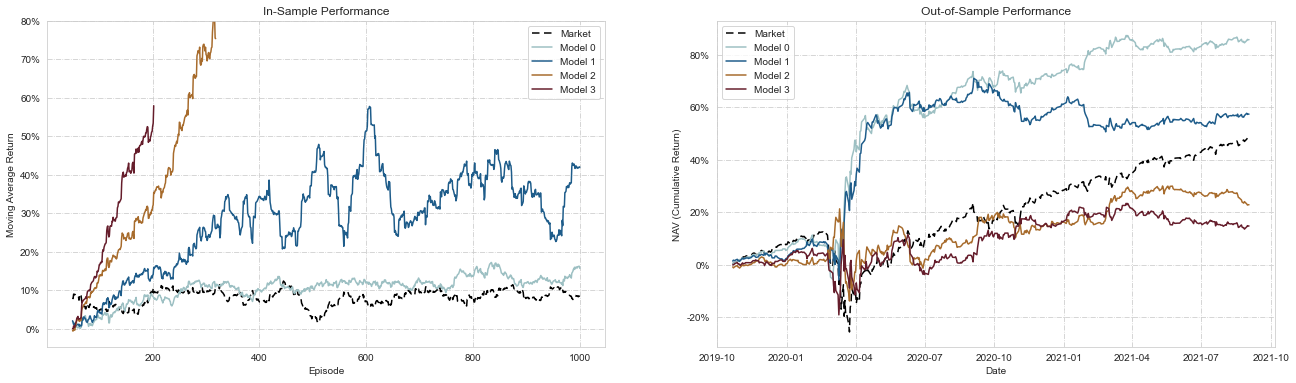

In [10]:
sns.set_style("whitegrid", {'grid.linestyle': '-.'})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 6))

axes[0].set_prop_cycle(color=["#000000", "#9DC0C3", "#1E5C8A", "#A76B2C", "#651D2B"])

axes[0].plot(train_res_nc.rolling(50).mean(), label = train_res_nc.columns, linewidth=1.5)
axes[0].set_ylim(top = 0.8)
axes[0].lines[0].set_linestyle((0, (5, 3)))
axes[0].legend(loc="upper right")
axes[0].title.set_text("In-Sample Performance")
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Moving Average Return')

axes[1].set_prop_cycle(color=["#000000", "#9DC0C3", "#1E5C8A", "#A76B2C", "#651D2B"])

axes[1].plot(test_res_nc, label = test_res_nc.columns, linewidth=1.5)
axes[1].set_xlim(left = datetime.strptime("2019-10-01", '%Y-%m-%d'))
axes[1].lines[0].set_linestyle((0, (5, 3)))
axes[1].legend(loc="upper left")
axes[1].title.set_text('Out-of-Sample Performance')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('NAV (Cumulative Return)')

for ax in axes:
    ax.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

## Train and Test Result with costs with 2 Year Test set (within crisis)


In [11]:
# Load Data
train_0_c = pd.read_csv("resu/no_rona/cost/train_0_c.csv", index_col = "Episode")
train_1_c = pd.read_csv("resu/no_rona/cost/train_1_c.csv", index_col = "Episode")
train_2_c = pd.read_csv("resu/no_rona/cost/train_2_c.csv", index_col = "Episode")
train_3_c = pd.read_csv("resu/no_rona/cost/train_3_c.csv", index_col = "Episode")

test_0_c = pd.read_csv("resu/no_rona/cost/test_0_c.csv", index_col = "Date")
test_1_c = pd.read_csv("resu/no_rona/cost/test_1_c.csv", index_col = "Date")
test_2_c = pd.read_csv("resu/no_rona/cost/test_2_c.csv", index_col = "Date")
test_3_c = pd.read_csv("resu/no_rona/cost/test_3_c.csv", index_col = "Date")

# Prepare Data for in-sample and out-of-sample performance
train_res_c = [train_0_c[["Market Ep NAV", "Agent Ep NAV"]], train_1_c[["Agent Ep NAV"]], train_2_c[["Agent Ep NAV"]], train_3_c[["Agent Ep NAV"]]]
train_res_c = pd.concat(train_res_c, axis = 1)
train_res_c.columns = ["Market", "Model 0", "Model 1", "Model 2", "Model 3"]

test_res_c = pd.merge(test_0_c.reset_index()[["Date", "Market NAV", "Agent NAV"]], test_1_c.reset_index()[["Date", "Agent NAV"]], on = "Date", how = "inner")
test_res_c = pd.merge(test_res_c, test_2_c.reset_index()[["Date", "Agent NAV"]], on = "Date", how = "inner")
test_res_c = pd.merge(test_res_c, test_3_c.reset_index()[["Date", "Agent NAV"]], on = "Date", how = "inner")
test_res_c = test_res_c.set_index("Date")
test_res_c.index = pd.to_datetime(test_res_c.index)
test_res_c.columns = ["Market", "Model 0", "Model 1", "Model 2", "Model 3"]

In [12]:
trading_cost_bps = 1e-4
time_cost_bps = 1e-5

mod_pred = test_0_c[["Market Return"]]
mod_pred[["Action"]] = "X"
mod_pred.columns = ["ret", "act"]

# Get postition of Actions that should be Long or Short
pos = np.where((abs(mod_pred.ret) > (2*trading_cost_bps)).astype(int) == 1)[0]
pos = mod_pred.index[pos]
mod_pred.loc[pos, "act"] = "Y"

# Replace All Y to 2 (Long) or 0 (Short)
def get_action(ret, act):
    if (float(ret) > 0) and (act[0] == "Y"):
        return(2)
    elif (float(ret) < 0) and (act[0] == "Y"):
        return(0)
    else: return("X")

mod_pred.act = mod_pred.apply(lambda x: get_action(x.ret, x.act), axis = 1)

# Handle Neutral Position
for i in range(1, len(mod_pred.index)):
    if (mod_pred.act.iloc[i-1] == 2) and (mod_pred.act.iloc[i] == "X"):
        if (mod_pred.ret.iloc[i] < 0):
            mod_pred.act.iloc[i] = 1
        else: mod_pred.act.iloc[i] = 2
    elif (mod_pred.act.iloc[i-1] == 0) and (mod_pred.act.iloc[i] == "X"):
        if (mod_pred.ret.iloc[i] > 0):
            mod_pred.act.iloc[i] = 1
        else: mod_pred.act.iloc[i] = 0
    elif (mod_pred.act.iloc[i-1] == 1) and (mod_pred.act.iloc[i] == "X"):
        if (mod_pred.ret.iloc[i] > trading_cost_bps):
            mod_pred.act.iloc[i] = 2
        elif (mod_pred.ret.iloc[i] < (-trading_cost_bps)):
            mod_pred.act.iloc[i] = 0
        else: mod_pred.act.iloc[i] = 1
    else: pass
mod_pred = mod_pred.drop(["ret"], axis = 1)
mod_pred["Market"] = 2

# Create Data Frame with all actions from all Models
df_action = pd.merge(mod_pred, test_0_c.reset_index()[["Date", "Action"]], on = "Date", how = "inner")
df_action = pd.merge(df_action, test_1_c.reset_index()[["Date", "Action"]], on = "Date", how = "inner")
df_action = pd.merge(df_action, test_2_c.reset_index()[["Date", "Action"]], on = "Date", how = "inner")
df_action = pd.merge(df_action, test_3_c.reset_index()[["Date", "Action"]], on = "Date", how = "inner")
df_action = df_action.set_index("Date")
df_action.index = pd.to_datetime(df_action.index)
df_action.columns = ["Target", "Long","Model 0", "Model 1", "Model 2", "Model 3"]
df_action = df_action - 1

# DataFrame with all daily Rewards from Market and ever Model
test_perf_c = pd.merge(test_0_c.reset_index()[["Date", "Market Return", "Agent Return"]],
                     test_1_c.reset_index()[["Date", "Agent Return"]],
                     on = "Date", how = "inner")
test_perf_c = pd.merge(test_perf_c, test_2_c.reset_index()[["Date", "Agent Return"]],
                     on = "Date", how = "inner")
test_perf_c = pd.merge(test_perf_c, test_3_c.reset_index()[["Date", "Agent Return"]],
                     on = "Date", how = "inner")
test_perf_c = test_perf_c.set_index("Date")
test_perf_c.index = pd.to_datetime(test_perf_c.index)
test_perf_c.columns = ["Market", "Model 0", "Model 1", "Model 2", "Model 3"]

# Get MSE and Accuracy scores
mse_c = []
accuracy_c = []
for i in range(1, len(df_action.columns)):
    mse_c.append(mean_squared_error(df_action.Target, df_action.iloc[:,i]))
    accuracy_c.append(accuracy_score(df_action.Target.tolist(), df_action.iloc[:,i]))

In [13]:
df_train_c = pd.DataFrame({"E(R)": (np.mean(train_res_c)*100).round(2).astype(str) + "%",
                         "std(R)": (np.std(train_res_c)*100).round(2).astype(str) + "%",
                         "Sharpe": (np.mean(train_res_c)/np.std(train_res_c)).round(3)})

df_test_c = pd.DataFrame({"E(R)": (np.mean(test_perf_c)*100*252).round(2).astype(str) + "%",
                        "std(R)":(np.std(test_perf_c)*100*np.sqrt(252)).round(2).astype(str) + "%",
                        "Sharpe": ( ( np.mean(test_perf_c)*252 )/ (np.std(test_perf_c) * np.sqrt(252))  ).round(3),
                        "MSE": np.around(mse_c,3),
                        "Accuracy": np.around(accuracy_c,3)})

In [14]:
df_train_c

,E(R),std(R),Sharpe
Market,7.66%,16.12%,0.475
Model 0,12.78%,21.0%,0.609
Model 1,41.27%,54.63%,0.755
Model 2,31.8%,51.92%,0.612
Model 3,31.96%,43.87%,0.729


In [15]:
df_test_c

,E(R),std(R),Sharpe,MSE,Accuracy
Market,22.32%,25.26%,0.883,1.680,0.568
Model 0,19.77%,25.18%,0.785,1.654,0.540
Model 1,22.87%,25.0%,0.915,1.758,0.490
Model 2,-5.47%,24.97%,-0.219,1.848,0.478
Model 3,15.91%,23.53%,0.676,1.784,0.458


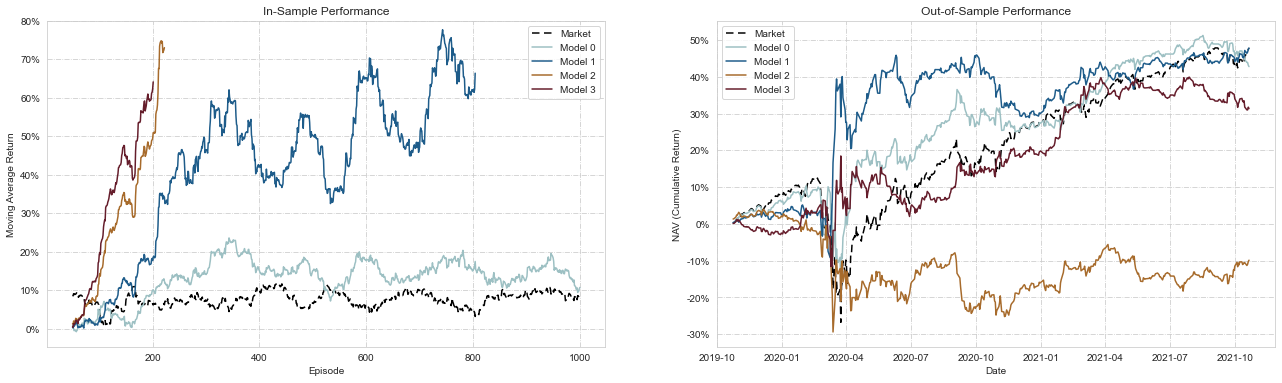

In [16]:
sns.set_style("whitegrid", {'grid.linestyle': '-.'})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 6))

axes[0].set_prop_cycle(color=["#000000", "#9DC0C3", "#1E5C8A", "#A76B2C", "#651D2B"])

axes[0].plot(train_res_c.rolling(50).mean(), label = train_res_c.columns, linewidth=1.5)
axes[0].set_ylim(top = 0.8)
axes[0].lines[0].set_linestyle((0, (5, 3)))
axes[0].legend(loc="upper right")
axes[0].title.set_text("In-Sample Performance")
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Moving Average Return')

axes[1].set_prop_cycle(color=["#000000", "#9DC0C3", "#1E5C8A", "#A76B2C", "#651D2B"])

axes[1].plot(test_res_c, label = test_res_c.columns, linewidth=1.5)
axes[1].set_xlim(left = datetime.strptime("2019-10-01", '%Y-%m-%d'))
axes[1].lines[0].set_linestyle((0, (5, 3)))
axes[1].legend(loc="upper left")
axes[1].title.set_text('Out-of-Sample Performance')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('NAV (Cumulative Return)')

for ax in axes:
    ax.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

In [17]:
test_1_c = pd.read_csv("resu/no_rona/high_cost/test_1_c.csv", index_col = "Date")
test_1_nc = pd.read_csv("resu/no_rona/high_cost/test_1_nc.csv", index_col = "Date")
train_1_c = pd.read_csv("resu/no_rona/high_cost/train_1_c.csv", index_col = "Episode")

In [18]:
# Get Random Action for random agent

trading_cost_bps = 1e-4
time_cost_bps = 1e-5

rand_action = np.array([random.randrange(0, 3, 1) for i in range(len(train_1_c.index))]) - 1
market_ret = train_1_c[["Market Ep NAV"]].values
rand_nav = np.zeros(len(train_1_c.index))
# Calculate Return for random agent
for i in range(len(train_1_c.index)):
    cur_position = rand_action[i]
    prev_position = rand_action[max(0, i - 1)]
    n_trades = cur_position - prev_position
    trade_costs = abs(n_trades) * trading_cost_bps
    time_cost = 0 if abs(n_trades) else time_cost_bps
    rand_nav[i] = (cur_position * market_ret[i]) - (trade_costs+time_cost)

rand_win = (pd.Series(list(map(operator.sub, rand_nav, market_ret))) > 0).rolling(100).sum()  # Random Agent Wins per 100 episodes.
agent_win = train_1_c["Strategy Wins (%)"]
agent_win.name = "Model 1"
rand_win.name = "Random Agent"
rand_win.index.name = "Episode"
df_outp_c = pd.merge(rand_win, agent_win, on="Episode", how = "inner")
df_outp_c = df_outp_c.div(100).rolling(50).mean()

# Create Epsilon vor visualization
epsilon_start = 1.0                 # epsilon start value
epsilon_end = .01                   # where it stops
epsilon_decay_steps = 250           # steps to decay
epsilon_exponential_decay = .99     # exponential decay multiplicator
epsilon_decay = (epsilon_start - epsilon_end) / epsilon_decay_steps
epsilon = 1.0
eps = np.zeros(len(train_1_c.index))

for episodes in range(len(train_1_c.index)):
    eps[episodes] = epsilon
    if episodes < epsilon_decay_steps:
        epsilon -= epsilon_decay
    else:
        epsilon *= epsilon_exponential_decay
eps = pd.Series(eps)
eps.name = "Epsilon"
eps.index.name = "Episode"

# Merge them together
df_mod1_c = train_1_c[["Market CumSum NAV", "Agent CumSum NAV"]]
df_mod1_c = pd.merge(df_mod1_c, eps, on="Episode", how="outer")
df_mod1_c.columns = ["Market", "Model 1", "Epsilon"]

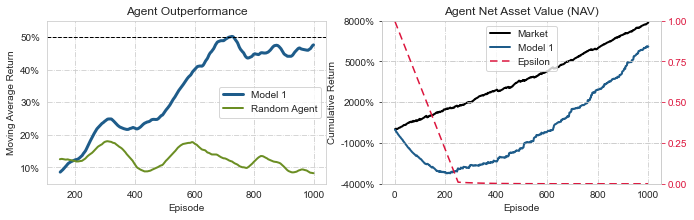

In [19]:
sns.set_style("whitegrid", {'grid.linestyle': '-.'})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 3))

axes[0].plot(df_outp_c[["Model 1"]], label = "Model 1", linewidth = 3, c = "#1E5C8A")
axes[0].plot(df_outp_c[["Random Agent"]], label = "Random Agent", linewidth = 2, c = "olivedrab")
axes[0].legend(loc="center right")
axes[0].set_ylim(bottom = .05, top = .55)
axes[0].title.set_text("Agent Outperformance")
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Moving Average Return')

axes[0].yaxis.set_major_formatter(
    FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].axhline(.5, ls='--', c='k', lw=1)

axes[1].set_prop_cycle(color=["#000000", "#1E5C8A"])
epscol = "crimson"
lin1 = axes[1].plot(df_mod1_c[["Market", "Model 1"]], label = ["Market", "Model 1"], linewidth = 2)
axes[1].set_ylim(bottom = -40, top = 80)
axes[1].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(5))
axes[1].title.set_text("Agent Net Asset Value (NAV)")
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Cumulative Return')

ax2 = axes[1].twinx()  # instantiate a second axes that shares the same x-axis
lin2 = ax2.plot(df_mod1_c.Epsilon, label = "Epsilon", c = epscol, linestyle = (0, (5, 3)))
ax2.tick_params(axis='y', labelcolor = epscol, color = epscol)
ax2.set_ylim(bottom = 0, top = 1)
ax2.yaxis.set_major_locator(matplotlib.ticker.LinearLocator(5))

lns = lin1+lin2
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc="upper center")

axes[1].yaxis.set_major_formatter(
    FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

In [20]:
dist_test_nc = np.array(test_1_nc[["Agent Return"]].rolling(20).mean())
dist_test_c = np.array(test_1_c[["Agent Return"]].rolling(20).mean())

act_nc = ["Long" if x == 2 else ("Neutral" if x == 1 else "Short") for x in test_1_nc.Action]
act_c = ["Long" if x == 2 else ("Neutral" if x == 1 else "Short") for x in test_1_c.Action]
act_nc = pd.DataFrame(act_nc, columns= ["Position"])
act_c = pd.DataFrame(act_c, columns= ["Position"])
act_c["Info"] = "Cost"
act_nc["Info"] = "No Cost"
act_mod1 = pd.concat([act_c, act_nc], ignore_index=True)

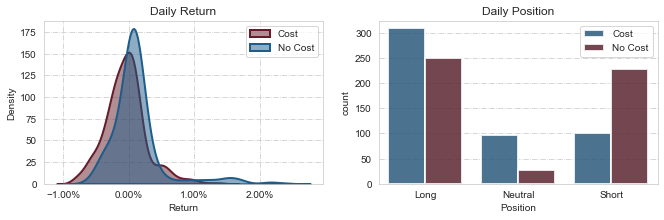

In [21]:
sns.set_style("whitegrid", {'grid.linestyle': '-.'})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 3))
sns.kdeplot(dist_test_c.flatten(), ax = axes[0], fill = True, label = "Cost", alpha=.5, linewidth=2, color = "#651D2B")
sns.kdeplot(dist_test_nc.flatten(), ax = axes[0], fill = True, label = "No Cost", alpha=.5, linewidth=2, color = "#1E5C8A")

axes[0].legend()
axes[0].title.set_text("Daily Return")
axes[0].set_xlabel('Return')
axes[0].xaxis.set_ticks(np.arange(-.01, .03, 0.01))
axes[0].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

axes[1].set_prop_cycle(color=["#000000", "#1E5C8A"])
ax2 = sns.countplot(data=act_mod1, x="Position", hue="Info", ax = axes[1],
                    palette = ["#1E5C8A","#651D2B"], alpha = .85,
                    linewidth=2)
ax2.legend_.set_title(None)
axes[1].title.set_text("Daily Position")